#Import Libraries

---






In [0]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [0]:
#@title
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [0]:
#@title
#installion requirements for GENSIM
import os
!pip install --upgrade gensim

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"   #set environment variable
  !java -version      #check java version
install_java()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use','test','%%subject%%','be','dd'])
#re
import re
import numpy as np
import pandas as pd
from pprint import pprint

#gensim

import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.test.utils import datapath


#spacy 
!pip install spacy
import spacy
!python -m spacy download en_core_web_lg


#plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

import os.path
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

# Import Dataset

---



In [0]:
data_df = pd.read_csv(r'/gdrive/My Drive/KAEMH/EmailSpamAnalysis/All_Email_Campaigns_02042020.csv')
df_sample=data_df.sample(frac=0.10)

In [0]:
def display_all(df):
  """ Function to display the whole dataframe"""
  with pd.option_context("display.max_rows",1000):
    with pd.option_context("display.max_columns",1000):
      display(df)

In [0]:
display_all(data_df)

#Data Pre-Processing with Spacy and Gensim

---



In [0]:
#convert the data to a list(SAMPLE)

data_list_sample = df_sample['Subject']

data_list_sample


In [0]:
data_list = data_df['Subject'].dropna()
data_list=data_list.values.tolist()
data_list

In [0]:
# Remove Emails
data_list = [re.sub('\S*@\S*\s?', '', sent) for sent in data_list]

# Remove new line characters
data_list = [re.sub('\s+', ' ', sent) for sent in data_list]

# Remove distracting single quotes
data_list = [re.sub("\'", "", sent) for sent in data_list]
data_list

In [0]:
#preprocess for the subject lines

def custom_cleaner(doc):

  tokens= [token.lemma_.lower()
              for token in doc 
                  if (
                    
                    len(token) >=2 and
                    token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'] and
                    token.text in nlp.vocab and
                    not token.like_url and
                    not token.like_num and
                    not token.is_digit and
                    not token.is_punct and
                    not token.is_space and
                    not token.is_stop    
                  )      
          ] 
  return ' '.join(tokens)

In [0]:
nlp = spacy.load('en_core_web_lg',disable=['parser','ner'])

nlp.add_pipe(custom_cleaner,name='cleaner',last=True)

clean_corpus = list(nlp.pipe(data_list))
clean_corpus_list= [i.split() for i in clean_corpus]
clean_corpus_list

In [0]:
# using gensim simple_preprocess - Additional preprocessing 

def sample_prepro(data):
  for sent in data:
      yield(gensim.utils.simple_preprocess(sent,deacc= True))

data_words = list(sample_prepro(clean_corpus))
data_words

##Creating bi-grams and tri-grams



In [0]:


bigram = gensim.models.Phrases(data_words,min_count=2 ,threshold=20)
trigram= gensim.models.Phrases(bigram[data_words],threshold=20)

#use the above mdoels to come up with the phrases

bigram_list=gensim.models.phrases.Phraser(bigram)
trigram_list = gensim.models.phrases.Phraser(trigram)

#printing the bigram and trigram

print(list(bigram_list[data_words]))
print(list(trigram_list[bigram_list[data_words[0]]]))

In [0]:
#remove extra stop words from the bigrams, trigrams and lemmetization


def remove_stopwords(texts):
  return [[word for word in gensim.utils.simple_preprocess(str(doc))if word not in stop_words]for doc in texts]

def make_bigrams(texts):
  return [bigram_list[doc] for doc in texts]

def make_trigrams(texts):
  yield ([trigram_list[doc] for doc in texts])



In [0]:
#function call for removal of additional stop_words and making bi-grams

data_words = remove_stopwords(data_words)

print(data_words)

data_words_final = make_bigrams(data_words)

In [0]:
# #optional function if spell correction is needed
# 
# # def spell_correction(word):
#   letters = 'abcdefghijklmnopqrstuvwxyz'
#   splits = [(word[:i],word[i:]) for i in range(len(word)+1)]
#   print(splits)
#   deletes = [L + R[1:] for L,R in splits if R]
#   print(deletes)
#   transposes = [L+R[1] + R[0] +R[2:] for L,R in splits if len(R)>1]
#   print(transposes)
#   replaces = [L + c+ R[1:] for L,R in splits if R for c in letters]
#   print(replaces)
#   inserts = [L+ c + R for L, R  in splits for c in letters]
#   print(inserts)

#   return set(deletes+transposes + replaces + inserts) 

# # def spell_final(word):
#   return(e2 for e1 in spell_correction(word) for e2 in edits1(e1))

#Dictionary and corpus - **Gensim**

In [0]:
#term document frequency

id2word = corpora.Dictionary(data_words_final)

corpus = [id2word.doc2bow(text) for text in data_words_final]
corpus

#Creating LDA Model

In [0]:
#training the model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 9,
                                           random_state=10,
                                           update_every=10,
                                           minimum_probability = 0.02,
                                           passes=10,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [0]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

#Find the Perplexity and Coherence score for the model

In [0]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.314392697255264

Coherence Score:  0.6037485892655053


#Visualizing the topics and words in each topic

In [0]:
#interactive charts
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.062674 -0.268302       1        1  18.715956
8     -0.306400 -0.061787       2        1  13.151935
4      0.182647 -0.071777       3        1  12.100361
3     -0.257900  0.159669       4        1  11.033761
7      0.085289 -0.186021       5        1   9.775183
5      0.043658  0.262142       6        1   9.551366
2      0.110943  0.125499       7        1   9.348783
1      0.043611 -0.021440       8        1   8.312418
6      0.160827  0.062017       9        1   8.010238, topic_info=    Category         Freq      Term        Total  loglift  logprob
446  Default  7657.000000     major  7657.000000  30.0000  30.0000
277  Default  7782.000000     bonus  7782.000000  29.0000  29.0000
486  Default  7489.000000    choose  7489.000000  28.0000  28.0000
24   Default  2614.000000   student  2614.000000  27.0000  27.0000
31   Default  3447.000000     visit  3447.000000  26.0000  26.0000
..       ...          ...       ...          ...      ...      ...
241   Topic9    90.198090  football   106.647873   2.3569  -5.0387
113   Topic9   152.848770     today   829.682007   0.8329  -4.5112
194   Topic9   112.693062    summer   708.526428   0.6859  -4.8160
96    Topic9   102.254364    career   557.078979   0.8292  -4.9132
27    Topic9    97.829597      help   429.283386   1.0456  -4.9575

[422 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
320       3  0.999459  abroad
651       4  0.992165  accept
324       3  0.049559  access
324       5  0.941620  access
119       4  0.994870  action
...     ...       ...     ...
207       3  0.139994    year
207       4  0.076530    year
207       7  0.563708    year
207       8  0.110128    year
207       9  0.080263    year

[552 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 5, 4, 8, 6, 3, 2, 7])

#Find out the optimal number of topics based on the coherence score - Gensim's LDA

In [0]:
#to find the right number of topic with LdaModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
  coherence_values = []
  perplexity_values=[]
  model_list = []
  for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,passes=50,minimum_probability=0.03)
      model_list.append(model)
      coherence_model_lda = CoherenceModel(model=model, texts=data_words_final, dictionary=id2word, coherence='c_v')
      coherence_values.append (coherence_model_lda.get_coherence())
      perplexity_values.append(model.log_perplexity(corpus))

  return model_list, coherence_values, perplexity_values

In [0]:
model_list , coherence_values,perplexity_values = compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_words_final,limit=20,start=2,step=1)
print(model_list)
print(coherence_values)
print(perplexity_values)


[<gensim.models.ldamodel.LdaModel object at 0x7f25db199978>, <gensim.models.ldamodel.LdaModel object at 0x7f25db2e1048>, <gensim.models.ldamodel.LdaModel object at 0x7f25f354b940>, <gensim.models.ldamodel.LdaModel object at 0x7f25db19dbe0>, <gensim.models.ldamodel.LdaModel object at 0x7f25d6ee2fd0>, <gensim.models.ldamodel.LdaModel object at 0x7f25d5c1a5f8>, <gensim.models.ldamodel.LdaModel object at 0x7f25db199fd0>, <gensim.models.ldamodel.LdaModel object at 0x7f25db2e6a20>, <gensim.models.ldamodel.LdaModel object at 0x7f25db199f98>, <gensim.models.ldamodel.LdaModel object at 0x7f25db2e6c50>, <gensim.models.ldamodel.LdaModel object at 0x7f25db199ac8>, <gensim.models.ldamodel.LdaModel object at 0x7f25db19da90>, <gensim.models.ldamodel.LdaModel object at 0x7f25db199f28>, <gensim.models.ldamodel.LdaModel object at 0x7f25db2e65c0>, <gensim.models.ldamodel.LdaModel object at 0x7f25db199e80>, <gensim.models.ldamodel.LdaModel object at 0x7f25db2e1470>, <gensim.models.ldamodel.LdaModel object

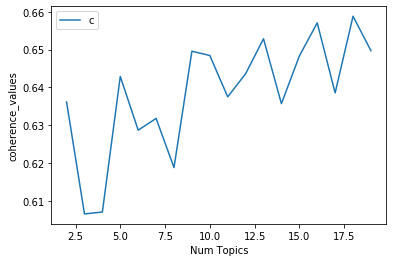

In [0]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("coherence_values")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
#printing coherence scores

for num_topic,score in zip(x,coherence_values):
  print("Number of topics:",num_topic,"has coherence score of:",round(score,4))

Number of topics: 2 has coherence score of: 0.6362
Number of topics: 3 has coherence score of: 0.6066
Number of topics: 4 has coherence score of: 0.6071
Number of topics: 5 has coherence score of: 0.6429
Number of topics: 6 has coherence score of: 0.6287
Number of topics: 7 has coherence score of: 0.6318
Number of topics: 8 has coherence score of: 0.6189
Number of topics: 9 has coherence score of: 0.6496
Number of topics: 10 has coherence score of: 0.6484
Number of topics: 11 has coherence score of: 0.6375
Number of topics: 12 has coherence score of: 0.6436
Number of topics: 13 has coherence score of: 0.6529
Number of topics: 14 has coherence score of: 0.6357
Number of topics: 15 has coherence score of: 0.6483
Number of topics: 16 has coherence score of: 0.6571
Number of topics: 17 has coherence score of: 0.6386
Number of topics: 18 has coherence score of: 0.6588
Number of topics: 19 has coherence score of: 0.6497


#LDA model with 5 topics - Compare the topic words manually 

In [0]:
#getting final LDA model to check the topics manually


lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 5,minimum_probability=0.08)

In [0]:
#TOPIC words 

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

*** topics - 10***


[(0,
  '0.110*"new" + 0.108*"benefit" + 0.068*"admit" + 0.046*"scholarship" + '
  '0.040*"year" + 0.039*"season" + 0.038*"email" + 0.038*"opportunity" + '
  '0.033*"ticket" + 0.032*"campus"'),
 (1,
  '0.126*"miss" + 0.110*"abroad" + 0.107*"ready" + 0.099*"experience" + '
  '0.082*"study" + 0.035*"celebrate" + 0.027*"plan" + 0.021*"graduation" + '
  '0.020*"future" + 0.020*"sms_connect"'),
 (2,
  '0.141*"event" + 0.084*"fall" + 0.075*"proof" + 0.048*"graduate" + '
  '0.039*"notification" + 0.037*"open" + 0.031*"available" + 0.026*"semester" '
  '+ 0.023*"class" + 0.023*"impact"'),
 (3,
  '0.575*"major" + 0.114*"natural" + 0.051*"student" + 0.034*"join" + '
  '0.023*"step" + 0.023*"schedule" + 0.021*"register" + 0.014*"support" + '
  '0.014*"gift" + 0.012*"time"'),
 (4,
  '0.517*"bonus" + 0.104*"super" + 0.102*"focused_futurist" + 0.059*"happy" + '
  '0.020*"meet" + 0.019*"sign" + 0.016*"enjoy" + 0.014*"information" + '
  '0.013*"spring" + 0.010*"day"'),
 (5,
  '0.255*"thank" + 0.135*"visit" + 0.098*"come" + 0.067*"message" + '
  '0.052*"program" + 0.047*"experience" + 0.040*"update" + 0.028*"deadline" + '
  '0.025*"career" + 0.019*"webinar"'),
 (6,
  '0.131*"group" + 0.099*"today" + 0.081*"visit" + 0.048*"chance" + '
  '0.038*"community" + 0.037*"honor" + 0.035*"health" + 0.033*"rsvp" + '
  '0.027*"notice" + 0.026*"free"'),
 (7,
  '0.127*"reminder" + 0.097*"transfer" + 0.094*"admission" + 0.080*"guarantee" '
  '+ 0.074*"start" + 0.072*"info" + 0.053*"pathway" + 0.034*"parking" + '
  '0.030*"visit" + 0.024*"summer"'),
 (8,
  '0.672*"choose" + 0.053*"education" + 0.051*"application" + '
  '0.036*"newsletter" + 0.025*"welcome" + 0.014*"help" + 0.011*"final" + '
  '0.010*"complete" + 0.007*"submit" + 0.006*"life"'),
 (9,
  '0.160*"interest" + 0.117*"glad" + 0.108*"invite" + 0.104*"apply" + '
  '0.064*"question" + 0.058*"decide" + 0.034*"birthday" + 0.028*"important" + '
  '0.027*"course" + 0.026*"date"')]


lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 4,
                                           random_state=10,
                                           update_every=10,
                                           minimum_probability = 0.02,
                                           passes=500,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

** Perplexity:  -6.089036716280999**

**Coherence Score:  0.6083991080444722 **

[(0,
  '0.055*"visit" + 0.043*"thank" + 0.034*"event" + 0.032*"come" + 0.031*"miss" '
  '+ 0.029*"invite" + 0.027*"experience" + 0.027*"reminder" + 0.019*"welcome" '
  '+ 0.017*"newsletter"'),

 (1,
  '0.039*"student" + 0.032*"happy" + 0.026*"new" + 0.020*"education" + '
  '0.020*"ready" + 0.018*"benefit" + 0.017*"fall" + 0.016*"today" + '
  '0.016*"step" + 0.015*"message"'),

 (2,
  '0.088*"admission" + 0.086*"application" + 0.055*"guarantee" + '
  '0.040*"question" + 0.030*"transfer" + 0.030*"info" + 0.028*"information" + '
  '0.027*"spring" + 0.022*"complete" + 0.019*"birthday"'),

 (3,
  '0.202*"choose" + 0.200*"major" + 0.195*"bonus" + 0.039*"natural" + '
  '0.039*"super" + 0.039*"focused_futurist" + 0.031*"apply" + 0.026*"glad" + '
  '0.025*"decide" + 0.022*"study"')]                                           

In [0]:
#interactive charts
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.262766 -0.067510       1        1  23.166109
2      0.173182 -0.119749       2        1  20.353382
3     -0.354476 -0.188335       3        1  20.181501
0     -0.010413 -0.026269       4        1  18.317116
1     -0.071059  0.401863       5        1  17.981899, topic_info=    Category          Freq      Term         Total  loglift  logprob
486  Default  15905.000000    choose  15905.000000  30.0000  30.0000
446  Default  14159.000000     major  14159.000000  29.0000  29.0000
277  Default  14603.000000     bonus  14603.000000  28.0000  28.0000
731  Default   4851.000000   natural   4851.000000  27.0000  27.0000
146  Default   2777.000000     happy   2777.000000  26.0000  26.0000
..       ...           ...       ...           ...      ...      ...
39    Topic5    208.047897  discover    208.703232   1.7127  -5.0114
110   Topic5    275.575958      good    276.791595   1.7114  -4.7303
291   Topic5    271.346100      news    272.634674   1.7111  -4.7458
478   Topic5    282.672241    design    284.637451   1.7089  -4.7049
194   Topic5    484.660004    summer    508.085999   1.6686  -4.1658

[205 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
320       2  0.998530     abroad
119       4  0.995724     action
49        1  0.996545  admission
49        5  0.003278  admission
269       3  0.998248      admit
...     ...       ...        ...
572       2  0.993684    webinar
337       2  0.997986       week
29        4  0.999311    welcome
211       1  0.991935        win
207       5  0.998935       year

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

In [0]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.851239529557142

Coherence Score:  0.641895575568632


#Get the most dominant topic in each subject line along with keywords

In [0]:
# #get dominant topic in each email subject line


# def get_dominant_topic(ldamodel=lda_model,corpus=corpus, texts=data_words_final):

#   subjectline_topic_df = pd.DataFrame()

#   for i,row in enumerate(ldamodel[corpus]):
#     # print(row)
#     row=sorted(row,key=lambda x: x[1],reverse=True)

#     for j,(t_num,t_prob) in enumerate(row):
#       print(j)
#       if j==0:
#         tp = ldamodel.show_topic(topic_num)
#         topic_keywords= ",".join([word for word, prob in tp])
#         subjectline_topic_df= subjectline_topic_df.append(pd.Series((int(topic_num),round(t_prob,4),topic_keywords)),ignore_index=True)
#       else:
#         break
#   subjectline_topic_df.columns= ['Dominant_topic_number','Topic_prob',"Key_words"]

#   original_text = pd.Series(texts)
#   subjectline_topic_df= pd.concat([subjectline_topic_df,original_text],axis=1)
#   return(subjectline_topic_df)


# df_subject_topic = get_dominant_topic(ldamodel=lda_model,corpus=corpus, texts=data_words_final)

# df_dominant_topic=df_subject_topic.reset_index()
# df_dominant_topic.columns =['Doc_no','Topic_num','Topic_prob','Keywords','Original_subject']

# df_dominant_topic.head()

#Save different trained model for future reference

In [0]:
#saving the model with 10 topics  (10 topics, auto, auto, probab = 0.01

lda_auto_10 = datapath("lda_auto_auto_10") 
lda_model.save(lda_auto_10)  

In [0]:
#load the save model for re-use

loaded_model = gensim.models.ldamodel.LdaModel.load(lda_auto_10,mmap='r')

In [0]:
#saving the model with 9 topics  (9 topics, auto, auto, probab = 0.03

lda_auto_4 = datapath("lda_auto_auto_4") 
lda_model.save(lda_auto_4)  

In [0]:
#saving the model with 9 topics  (9 topics, auto, auto, probab = 0.03


lda_auto_9 = datapath("lda_auto_auto_9") 
lda_model.save(lda_auto_9)   

In [0]:
# save the model - 1st model(with all data)

lda_auto_auto = datapath("lda_auto_auto_10033") # (random_state=10, update_every=10,passes=100,alpha='auto', eta = 'auto')
lda_model.save(lda_auto_auto)                                         
                                           
                                          

In [0]:
#load the save model for re-use

loaded_model = gensim.models.ldamodel.LdaModel.load(lda_auto_auto_4,mmap='r')

#LDAMallet

In [0]:
#Use of LDA mallet model
num_topics  = 8
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path = mallet_path, id2word = id2word, corpus=corpus,num_topics =num_topics,random_seed=1301)

In [0]:
#print the topic with Mallet

pprint(ldamallet.show_topics(formatted=False))

In [0]:
#find the coherence socre

coherence_model_mallet = CoherenceModel(model = ldamallet, texts= data_words_final, dictionary= id2word, coherence='c_v')
coherence_mallet = coherence_model_mallet.get_coherence()
print("Coherence with Mallet model is:", coherence_mallet)

Coherence with Mallet model is: 0.5995292431493597


#Get dominant topic in each email subject line

In [0]:

def get_dominant_topic(ldamodel=ldamallet,corpus=corpus, texts=data_words_final):

  subjectline_topic_df = pd.DataFrame()

  for i,row in enumerate(ldamodel[corpus]):
    # print(row)
    row=sorted(row,key=lambda x: x[1],reverse=True)

    for j,(t_num,t_prob) in enumerate(row):
      # print(j)
      if j==0:
        tp = ldamodel.show_topic(t_num)
        topic_keywords= ",".join([word for word, prob in tp])
        subjectline_topic_df= subjectline_topic_df.append(pd.Series([int(t_num),round(t_prob,4),topic_keywords]),ignore_index=True)
      else:
        break
  subjectline_topic_df.columns= ['Dominant_topic_number','Topic_prob',"Key_words"]

  original_text = pd.Series(texts)
  subjectline_topic_df= pd.concat([subjectline_topic_df,original_text],axis=1)
  return(subjectline_topic_df)


df_subject_topic = get_dominant_topic(ldamodel=ldamallet,corpus=corpus, texts=data_words_final)

df_dominant_topic=df_subject_topic.reset_index()
df_dominant_topic.columns =['DocNum','TopicNum','TopicPercentContribution','Keywords','OriginalSubject']


In [0]:
display_all(df_dominant_topic)

#Get dominant subject line represented for each topic

In [0]:
#increase the size of the column

pd.options.display.max_colwidth = 100

subjectline_for_topic_df = pd.DataFrame()

subject_topic_grouped = df_subject_topic.groupby('Dominant_topic_number')

for i, group in subject_topic_grouped:
  # print(group)
  subjectline_for_topic_df = pd.concat([subjectline_for_topic_df,group.sort_values(['Topic_prob'],ascending=False).head(1)],axis=0)

# subjectline_for_topic_df=subjectline_for_topic_df.copy()
subjectline_for_topic_df.reset_index(drop=True,inplace=True)

subjectline_for_topic_df.columns=['TopicNum','TopicPercentContribution','TopicKeywords','MostRepresentiveOriginalSubject']

subjectline_for_topic_df.head(10)

#Frequency of word counts in Documents

<Figure size 1000x500 with 0 Axes>

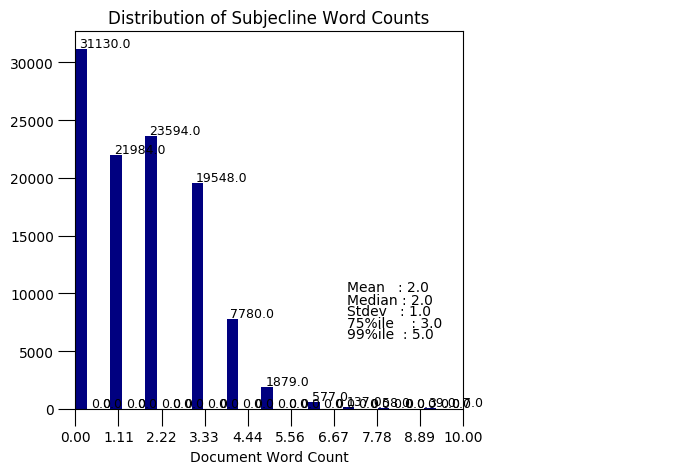

In [0]:
doc_lens = [len(d) for d in df_dominant_topic.OriginalSubject]
# print(doc_lens)
# Plot

plt.figure(figsize=(10,5), dpi=100)
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
plt.hist(doc_lens, bins = 50, color='navy')
plt.text(7,10210, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(7,9110, "Median : " + str(round(np.median(doc_lens))))
plt.text(7, 8110, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(7, 7110, "75%ile    : " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(7, 6110, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0,1), xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,10,10))
plt.title('Distribution of Subjecline Word Counts', fontdict=dict(size=12))
# plt.yticks(False)


for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+200),fontsize=9)
# Show graphic


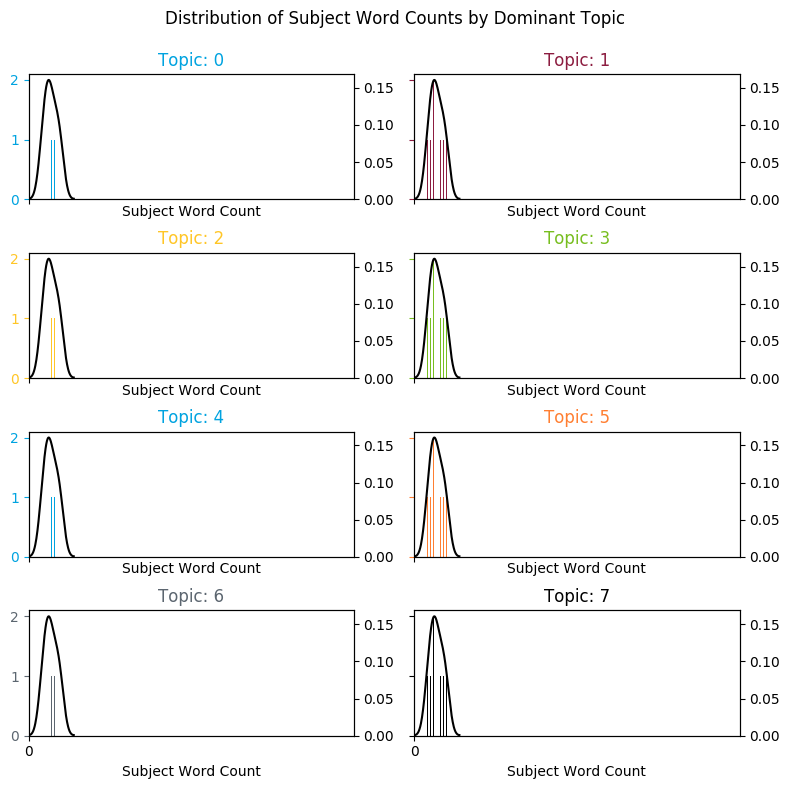

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = ['#00A3E0','#8C1D40','#FFC627','#78BE20','#00A3E0','#FF7F32','#5C6670','#000000']  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(8,8), dpi=100, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()): 
    # print(i)   
    df_dominant_topic_sub = subjectline_for_topic_df.loc[subjectline_for_topic_df.TopicNum == i, :]
    doc_lens = [len(d) for d in subjectline_for_topic_df.MostRepresentiveOriginalSubject]
    ax.hist(doc_lens, bins = 50, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Subject Word Count')
    ax.set_title('Topic: '+str(i), fontdict=dict(size=12, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,10,1))
fig.suptitle('Distribution of Subject Word Counts by Dominant Topic', fontsize=12)
plt.show()

#WordClouds for both the Models

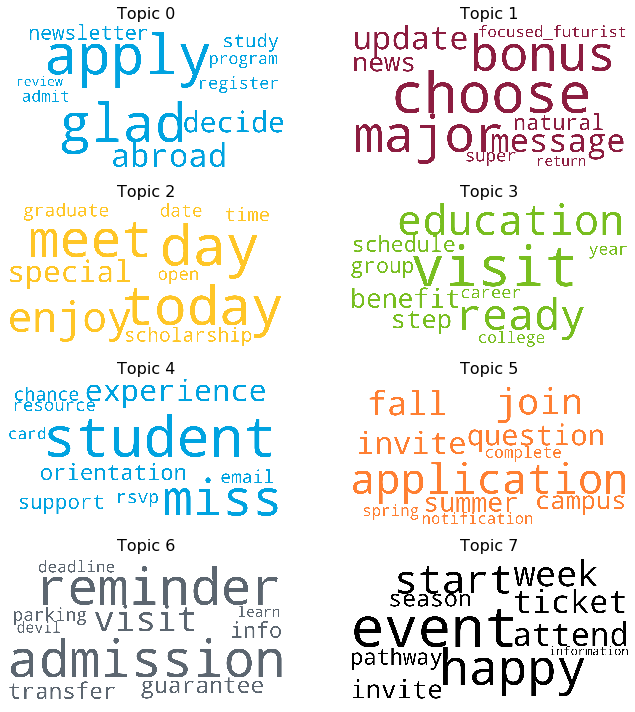

In [0]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = ['#00A3E0','#8C1D40','#FFC627','#78BE20','#00A3E0','#FF7F32','#5C6670','#000000']  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1500,
                  height=800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamallet.show_topics(formatted=False)

fig, axes = plt.subplots(4,2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.title("Results for LDA Mallet",fontsize=22)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

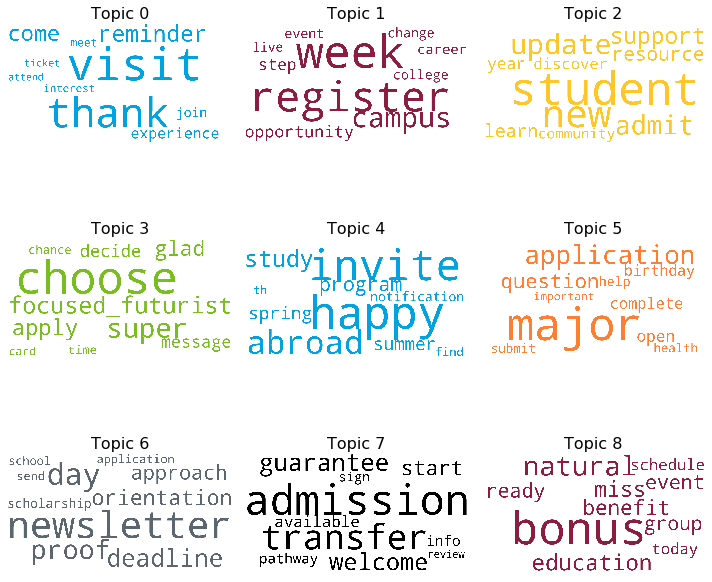

In [0]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = ['#00A3E0','#8C1D40','#FFC627','#78BE20','#00A3E0','#FF7F32','#5C6670','#000000','#8C1D40']  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1500,
                  height=800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics =lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.title("Results for LDA Gensim",fontsize=22)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [0]:

# from sklearn.manifold import TSNE
# from bokeh.plotting import figure, output_file, show
# from bokeh.models import Label
# # from bokeh.io import output_notebook

# # Get topic weights
# topic_weights = []
# # for i, row_list in enumerate(lda_model[corpus]):
# #     print(row_list)
# #     print(i)
# #     topic_weights.append([w for i, w in row_list[0]])

# for row_list in ldamallet[corpus]:
#   tmp = np.zeros(num_topics)
#   for i, w in row_list:
#     tmp[i] = w
#     topic_weights.append(tmp)

# # Array of topic weights    
# arr = pd.DataFrame(topic_weights).fillna(0).values

# # Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# # Dominant topic number in each doc
# topic_num = np.argmax(arr, axis=1)

# # tSNE Dimension Reduction
# tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
# tsne_lda = tsne_model.fit_transform(arr)


In [0]:
# # Plot the Topic Clusters using Bokeh
# output_notebook()
# n_topics = 4

# mycolors = np.array(['#00A3E0','#8C1D40','#FFC627','#78BE20','#00A3E0','#FF7F32','#5C6670','#000000'])
# plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
#               plot_width=900, plot_height=700)
# plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
# show(plot)

##Find out the optimal number of topics based on the coherence score- LDA Mallet


In [0]:
#find the right number of topics for the document

def compute_coherence_score(dictionary, corpus, texts, limit, start=5, step=2):
  """Compute Coherence score for different values of num of topics"""
  coherence_values = []

  model_list = []
  for num_topics in range(start,limit,step):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics= num_topics,id2word=id2word,random_seed=1301, )
    model_list.append(model)
    coherencescore = CoherenceModel(model=model, texts=data_words_final, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencescore.get_coherence())
  

  return model_list, coherence_values

In [0]:
model_list , coherence_values = compute_coherence_score(dictionary=id2word,texts=data_words_final,corpus=corpus,limit=20,start=3,step=1)


In [0]:
print(model_list)
print(coherence_values)

[<gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f7fc10f0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb26fa003c8>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1fd3acf28>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f807c208>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f8038dd8>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f7f6c860>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f7fbd0b8>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f8006748>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb26b341b70>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f7f76588>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f7fdcd68>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f7f76518>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f42fc710>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7fb1f8006588>, <gens

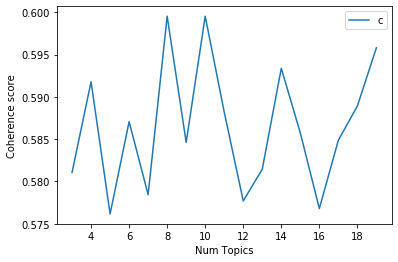

In [0]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
# find the score by the num of topics

for num,score in zip(x,coherence_values):
  print("For number of topics:",num,"the coherence score is:",score)

For number of topics: 3 the coherence score is: 0.5810603454055144
For number of topics: 4 the coherence score is: 0.5917841470009003
For number of topics: 5 the coherence score is: 0.5761583804122952
For number of topics: 6 the coherence score is: 0.5870650811343384
For number of topics: 7 the coherence score is: 0.5784304079242164
For number of topics: 8 the coherence score is: 0.5995292431493597
For number of topics: 9 the coherence score is: 0.5846227185183925
For number of topics: 10 the coherence score is: 0.5995278359113462
For number of topics: 11 the coherence score is: 0.5882039047036874
For number of topics: 12 the coherence score is: 0.5776899674960018
For number of topics: 13 the coherence score is: 0.5814520264317216
For number of topics: 14 the coherence score is: 0.5933732413864845
For number of topics: 15 the coherence score is: 0.5857325224626232
For number of topics: 16 the coherence score is: 0.5767939910375994
For number of topics: 17 the coherence score is: 0.5848